In [1]:
import os, sys
sys.path.insert(0, '/home/jtorrenc/mvesc/ETL')
sys.path.insert(0, '/home/jtorrenc/mvesc/ModelsResults')

from mvesc_utility_functions import *
from estimate_prediction_model import *
import numpy as np
import pandas as pd
import random
from functools import partial
import itertools
import pickle
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filename = '08_12_2016_grade_10_param_set_22_RF_ht_23591'


with open('/mnt/data/mvesc/Models_Results/pkls/'+filename+'_RF.pkl', "rb" ) as f:
    d = pickle.load(f)
model_options = d['model_options']
d.keys()


dict_keys(['train_y', 'features', 'model_options', 'parameter_grid', 'val_set_soft_preds', 'train_set_preds', 'estimator', 'time', 'test_set_preds', 'val_y', 'train_set_balance', 'val_set_preds', 'file_name', 'test_y', 'train_set_soft_preds', 'test_set_soft_preds', 'cross_validation_scores', 'model_name'])

In [3]:
model = d['estimator']

In [4]:
len(model.feature_importances_)

86

In [23]:
outcome_plus_features = build_outcomes_plus_features(model_options,None)
outcome_plus_features.dropna(subset=[model_options['outcome_name'],
        model_options['cohort_grade_level_begin']], inplace=True)

In [24]:
train, val, test = temporal_cohort_test_split(outcome_plus_features,
            model_options['cohort_grade_level_begin'],
            model_options['cohorts_test'],
            model_options['cohorts_val'],
            model_options['cohorts_training'])

In [25]:
train_X = train.drop([model_options['outcome_name'],
                      model_options['cohort_grade_level_begin']],axis=1)
test_X = test.drop([model_options['outcome_name'],
                    model_options['cohort_grade_level_begin']],axis=1)
val_X = val.drop([model_options['outcome_name'],
                  model_options['cohort_grade_level_begin']],axis=1)
train_y = train[model_options['outcome_name']]
test_y = test[model_options['outcome_name']]
val_y = val[model_options['outcome_name']]

print(len(train_X.columns))

91


In [33]:
[print(a, train_X[a].sum()) for a in train_X.columns if 'status' in a ]

status_gr_9_1 0.0
status_gr_9_2 0.0
status_gr_9_4 0.0
status_gr_9_6 1.0
status_gr_9_7 0.0
status_gr_9_deleted 2.0
status_gr_9_esc 9.0
status_gr_9_excel 4.0
status_gr_9_foster 16.0
status_gr_9_inactive 175.0
status_gr_9_nova_net_home 0.0
status_gr_9_open_enrollment 404.0
status_gr_9_three_way 1.0
status_gr_9_nan 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [34]:
train_X, val_X, test_X = impute_missing_values(train_X, val_X, test_X,\
    model_options['missing_impute_strategy'])
assert (all(train_X.columns == test_X.columns)),\
    "train and test have different columns"
print(len(train_X.columns))

108


In [35]:
train_X, val_X, test_X = scale_features(train_X, val_X, test_X,
    model_options['feature_scaling'])
assert (all(train_X.columns == test_X.columns)),\
    "train and test have different columns"
print(len(train_X.columns))

85


In [36]:
binary_features = pd.DataFrame(~train_X.apply(lambda x: len(x.unique()),axis=0).gt(2), columns = ['binary'])
len(binary_features)

85

In [37]:
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        cursor.execute("""select feature,importance from model.feature_scores
                                where filename = '{}'; """.format(filename))
        temp = cursor.fetchall()
scores = pd.DataFrame(temp, columns = ['feature','importance'])
len(scores)

85

In [43]:
scores.set_index('feature', inplace=True)

In [241]:
[c for c in list(train_X.columns) if 'status_gr_9' in c]

['status_gr_9_6',
 'status_gr_9_deleted',
 'status_gr_9_esc',
 'status_gr_9_excel',
 'status_gr_9_foster',
 'status_gr_9_inactive',
 'status_gr_9_open_enrollment',
 'status_gr_9_three_way']

In [41]:
train_X[train_X['section_504_plan_gr_9_0']==1]

,ethnicity_A,ethnicity_B,ethnicity_H,ethnicity_I,ethnicity_M,ethnicity_nan,gender_F,disadvantagement_gr_9_academic,disadvantagement_gr_9_both,disadvantagement_gr_9_economic,...,read_normalized_gr_7,math_normalized_gr_7,math_normalized_gr_6,read_normalized_gr_5,tardy_gr_9,read_normalized_gr_8,oss_gr_9,iss_gr_9,math_normalized_gr_5,science_normalized_gr_5
student_lookup,,,,,,,,,,,,,,,,,,,,,
42545.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
for a in train_X.columns:
    if a not in scores.index:
        print(a)

section_504_plan_gr_9_0


In [45]:
for a in scores.index:
    if a not in train_X.columns:
        print(a)  

status_gr_9_full_college


In [49]:
print(len(train_X.columns))
print(len(scores))
print(model.n_features_)

85
85
86


In [138]:
scores = scores.merge(binary_features, left_index=True, right_index=True)

In [139]:
scores.dtypes

importance    float64
binary           bool
dtype: object

/home/jgutman/env/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


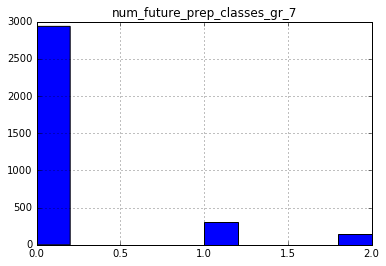

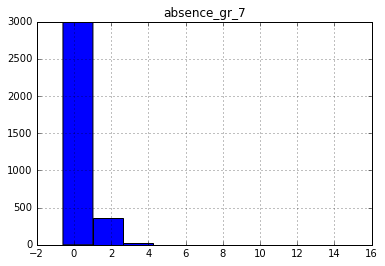

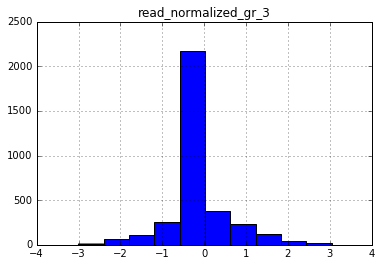

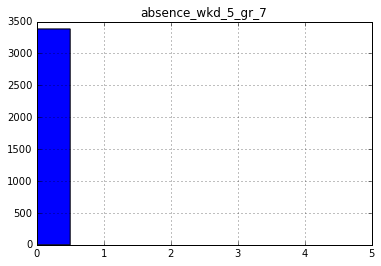

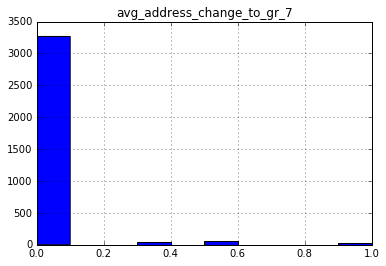

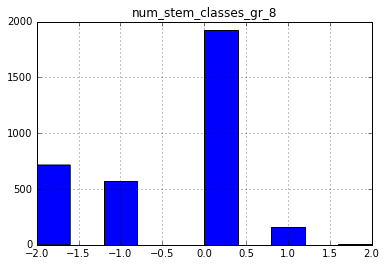

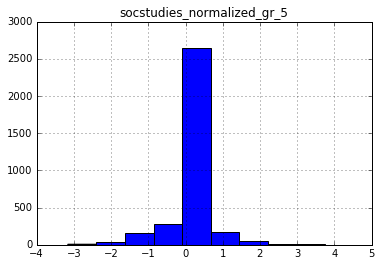

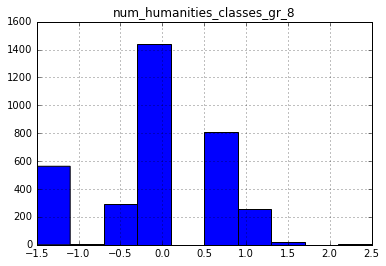

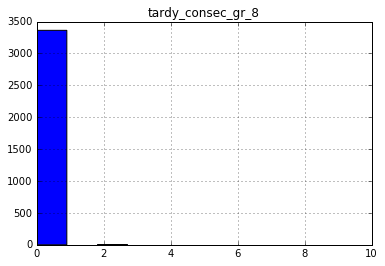

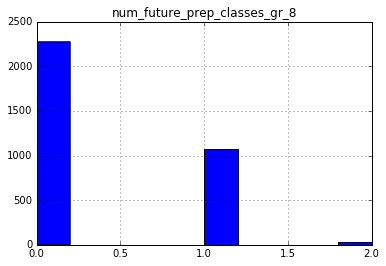

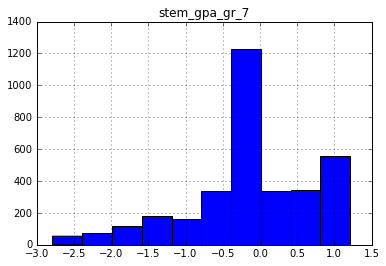

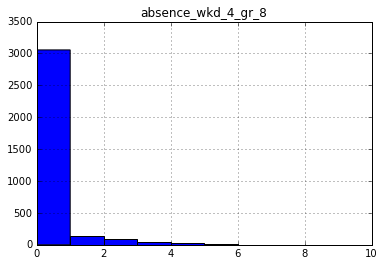

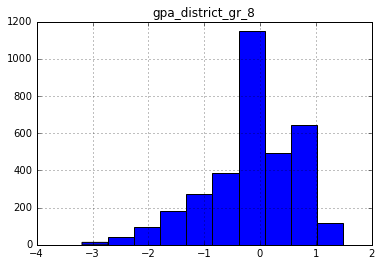

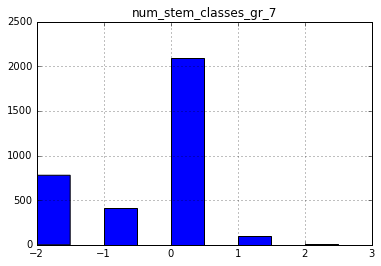

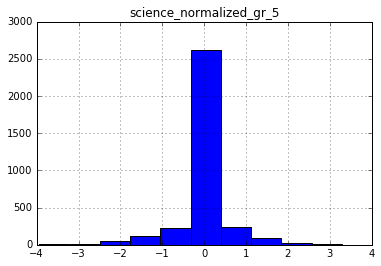

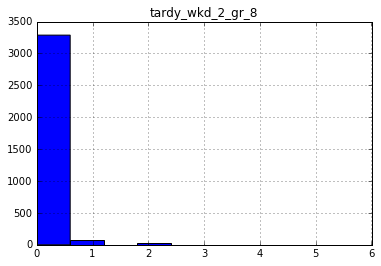

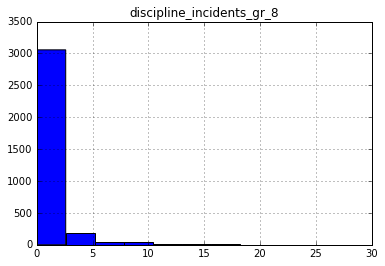

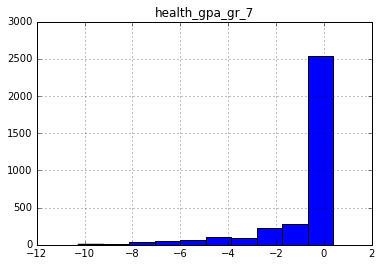

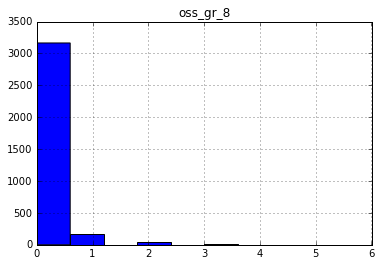

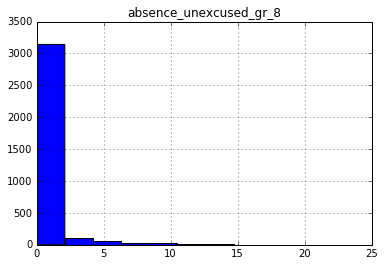

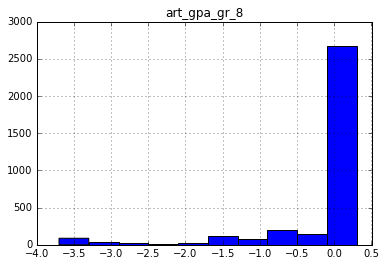

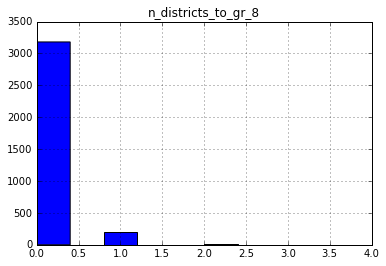

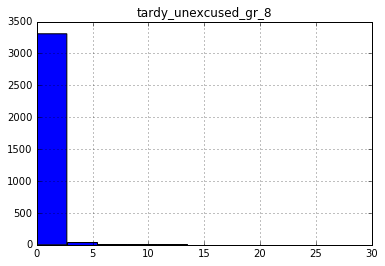

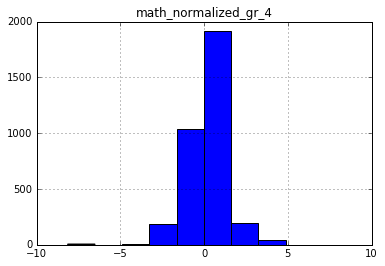

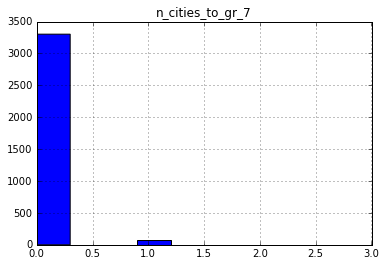

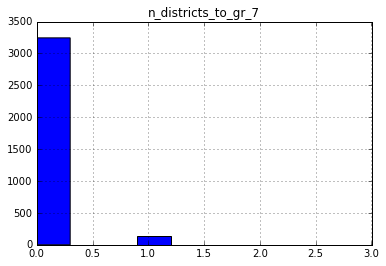

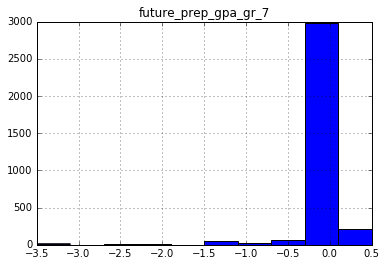

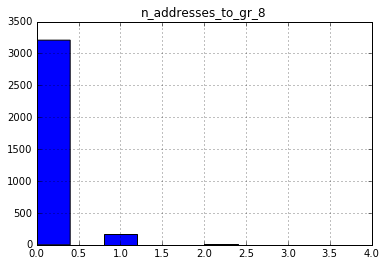

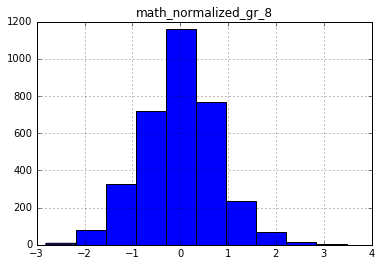

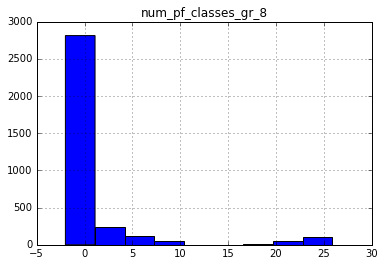

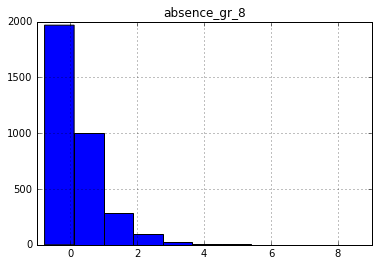

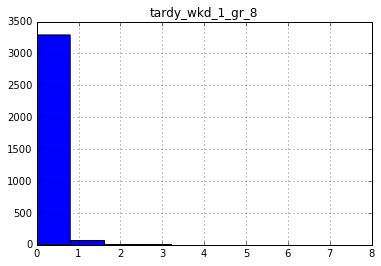

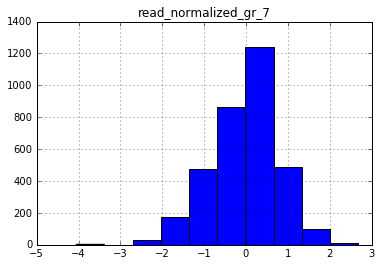

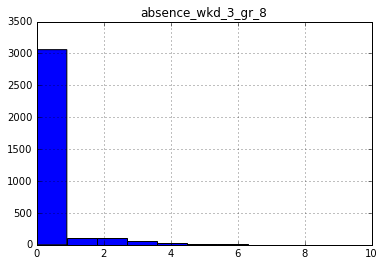

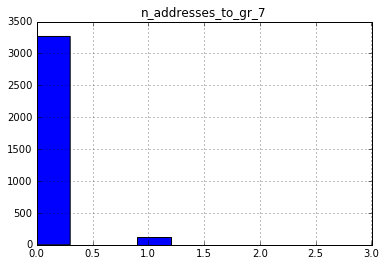

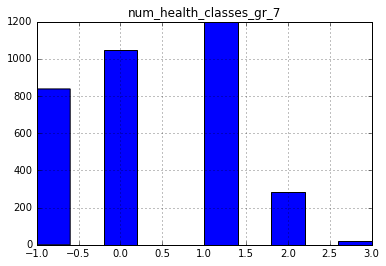

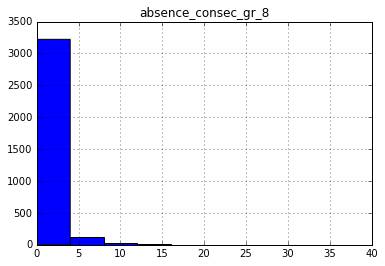

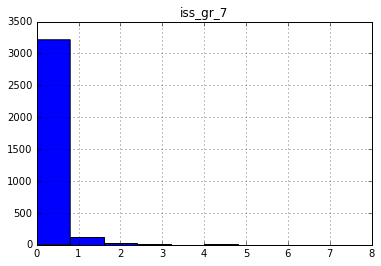

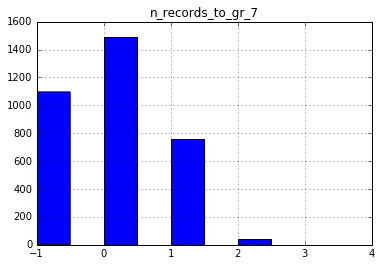

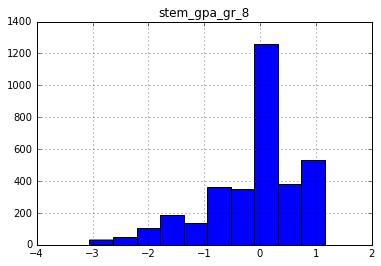

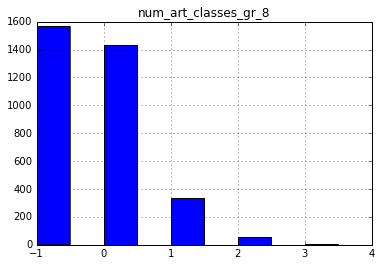

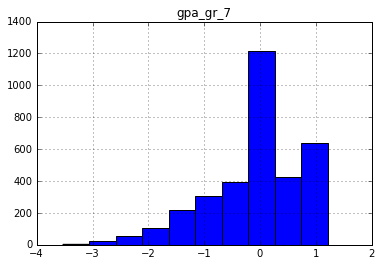

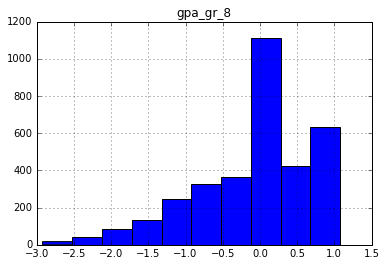

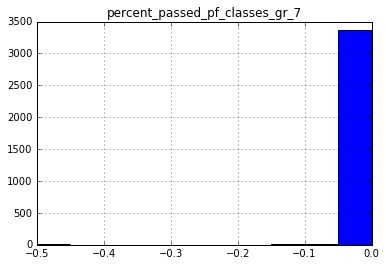

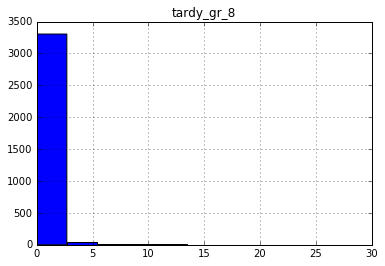

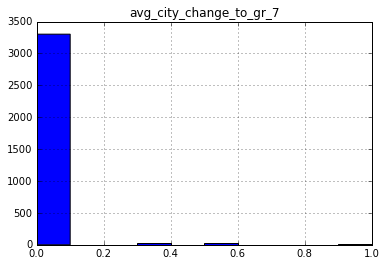

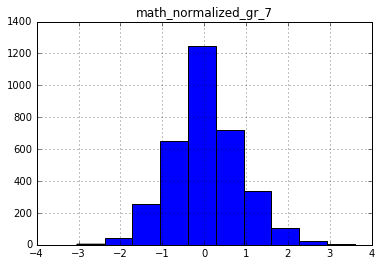

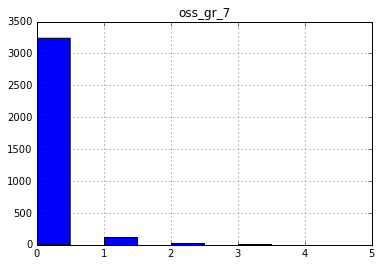

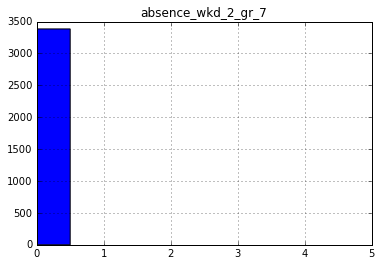

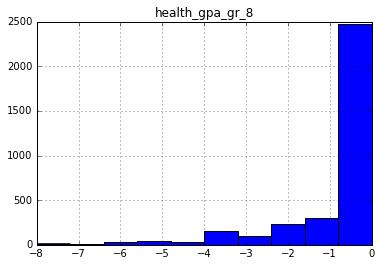

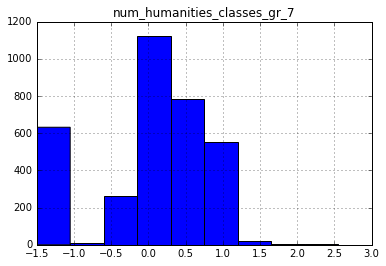

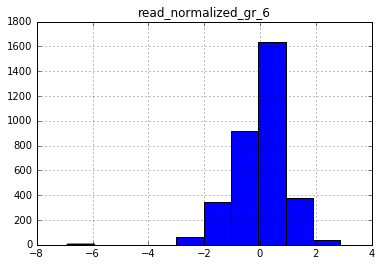

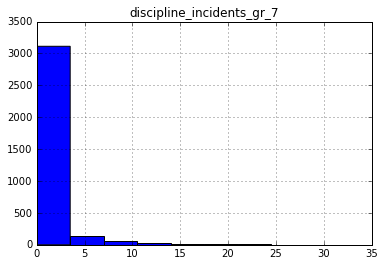

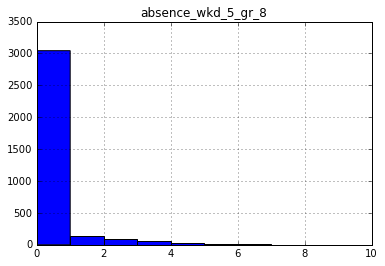

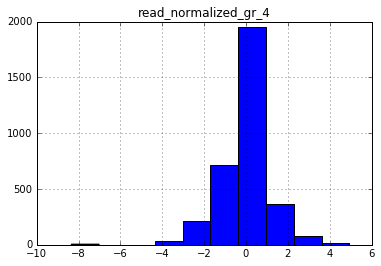

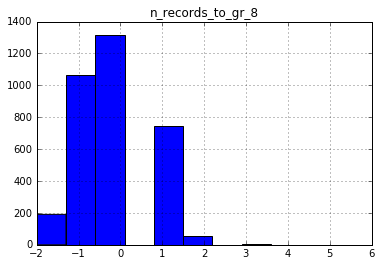

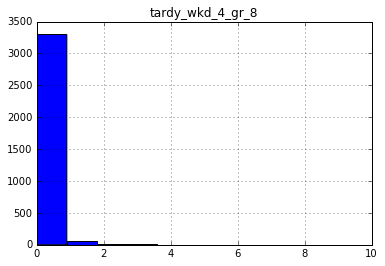

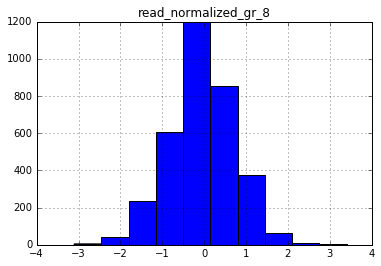

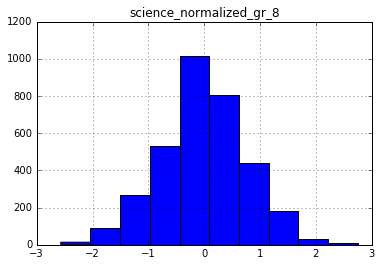

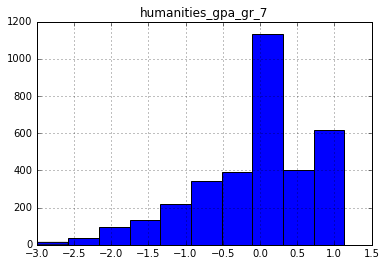

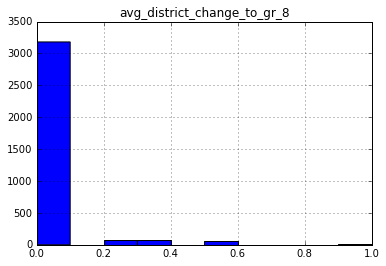

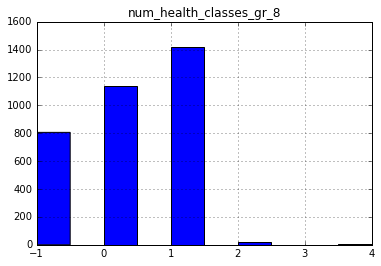

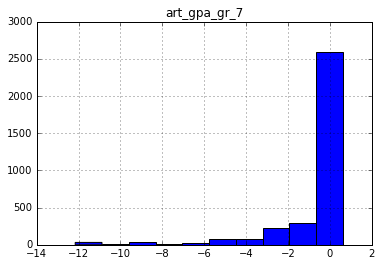

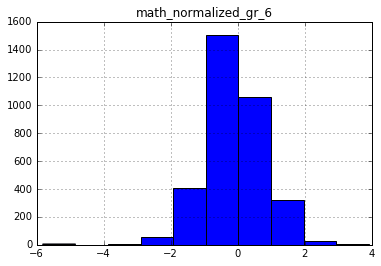

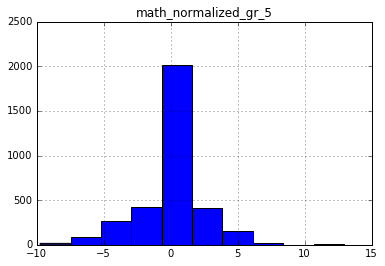

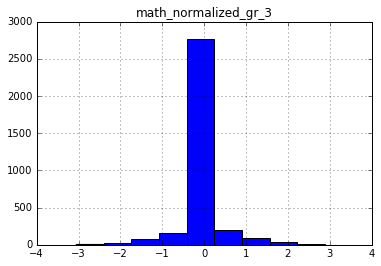

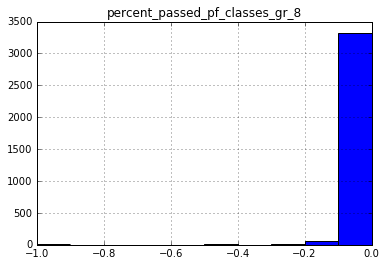

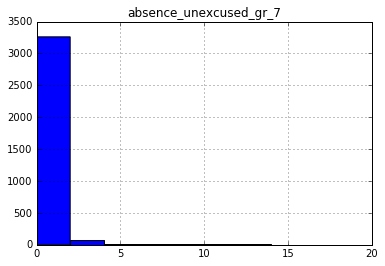

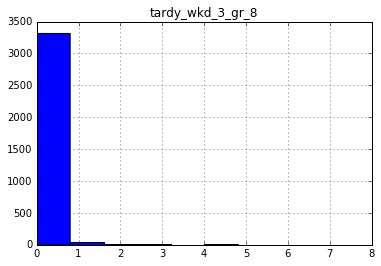

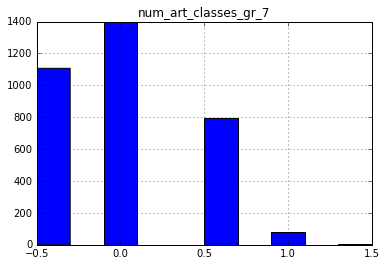

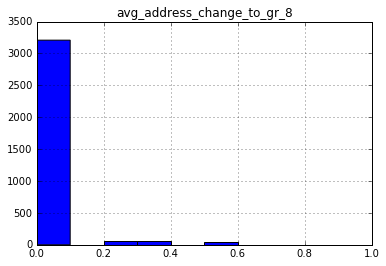

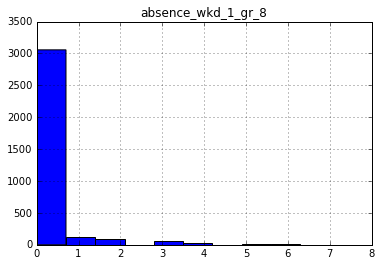

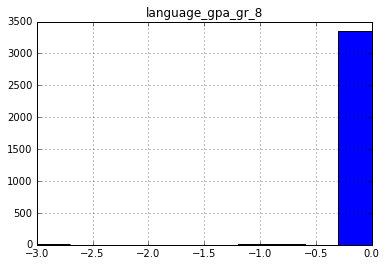

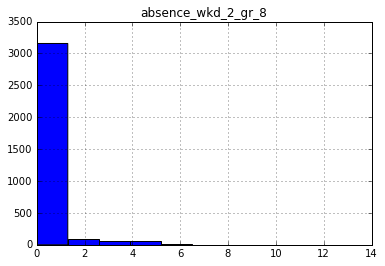

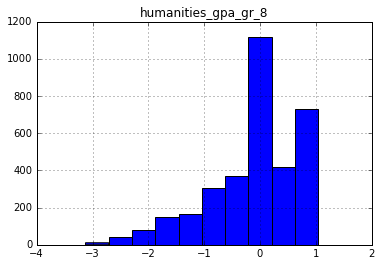

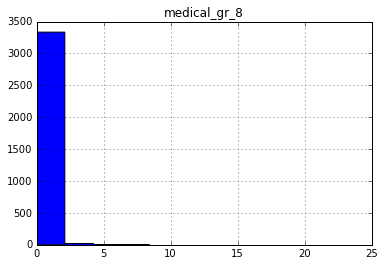

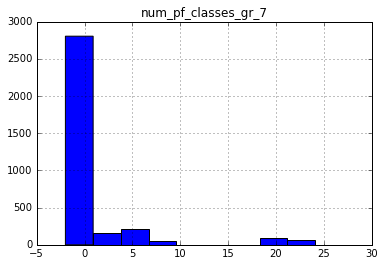

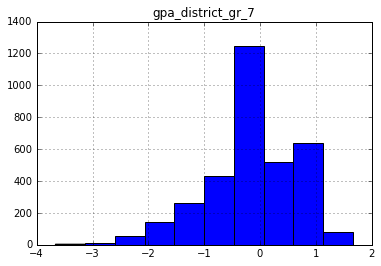

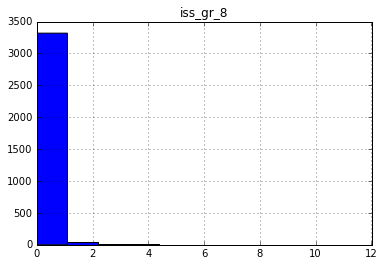

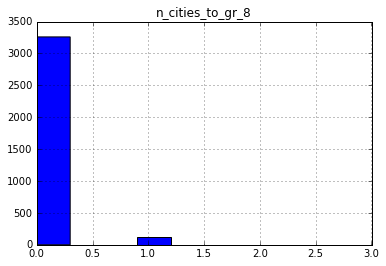

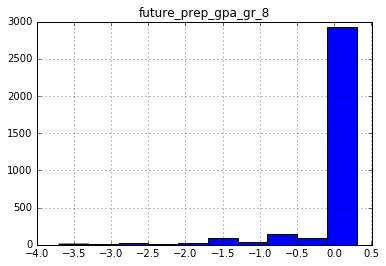

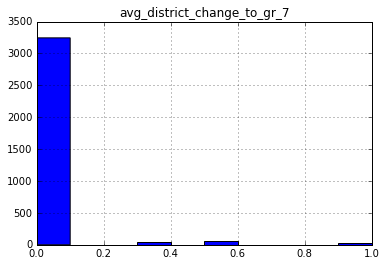

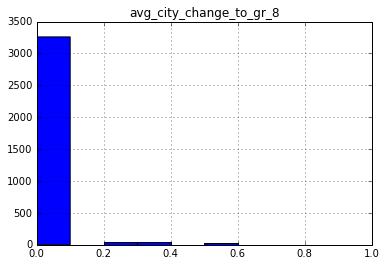

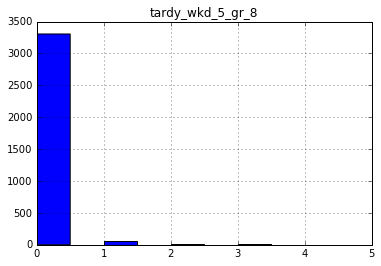

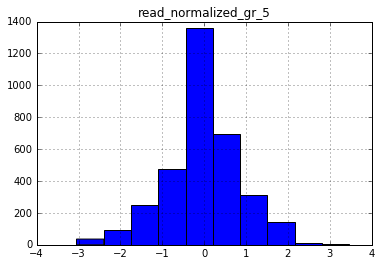

In [140]:
for c in train_X.columns[train_X.columns.isin(scores[~scores['binary']].index)]:
    plt.figure()
    train_X[c].hist()
    plt.title(c)

In [141]:
scores_weighted = scores
scores_weighted[~scores_weighted['binary']] = scores[~scores['binary']][['importance']]*5

In [142]:
scores.sort_values('importance',ascending=False)

,importance,binary
gpa_gr_8,0.209790,NaN
gpa_district_gr_7,0.205726,NaN
gpa_gr_7,0.194730,NaN
gpa_district_gr_8,0.193696,NaN
read_normalized_gr_8,0.171154,NaN
math_normalized_gr_8,0.168677,NaN
read_normalized_gr_7,0.166619,NaN
humanities_gpa_gr_7,0.166574,NaN
humanities_gpa_gr_8,0.154210,NaN
science_normalized_gr_8,0.147090,NaN


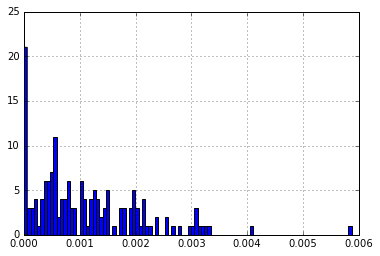

In [143]:
scores[scores['binary']==1]['importance'].hist(bins=100)

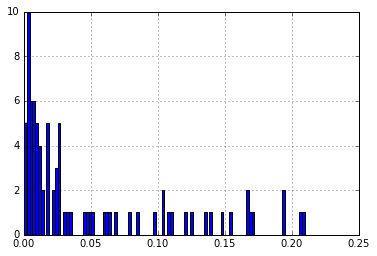

In [144]:
(scores[~(scores['binary']==1)]['importance']).hist(bins=100)

In [145]:
scores[~(scores['binary']==1)].sort_values('importance')

,importance,binary
language_gpa_gr_8,0.000017,NaN
absence_wkd_5_gr_7,0.000255,NaN
absence_wkd_2_gr_7,0.000354,NaN
tardy_consec_gr_8,0.001742,NaN
tardy_wkd_4_gr_8,0.001844,NaN
tardy_wkd_5_gr_8,0.002521,NaN
n_addresses_to_gr_7,0.002619,NaN
n_districts_to_gr_7,0.002893,NaN
n_cities_to_gr_7,0.002988,NaN
medical_gr_8,0.003434,NaN


/home/jgutman/env/lib/python3.4/site-packages/pandas/indexes/base.py:1275: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 251 but corresponding boolean dimension is 249
  result = getitem(key)


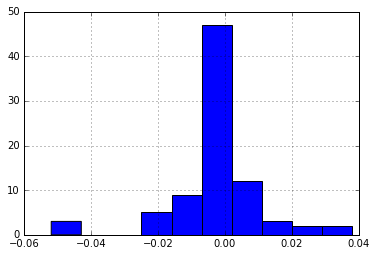

In [146]:
(train_X[train_X.columns[~(scores['binary']==1)]]*scores['importance'][~(scores['binary']==1)]).mean(axis=0).hist()


/home/jgutman/env/lib/python3.4/site-packages/pandas/indexes/base.py:1275: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 251 but corresponding boolean dimension is 249
  result = getitem(key)


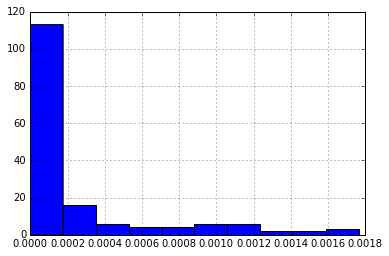

In [147]:
(train_X[train_X.columns[(scores['binary']==1)]]*scores['importance'][(scores['binary']==1)]).mean(axis=0).hist()


In [148]:
pd.DataFrame((train_X*scores['importance']).mean(axis=0), columns=['importance']).sort_values('importance', ascending=False)

,importance
discipline_incidents_gr_8,0.037993
num_pf_classes_gr_8,0.033813
discipline_incidents_gr_7,0.028136
num_pf_classes_gr_7,0.025350
absence_unexcused_gr_8,0.019211
absence_gr_7,0.013965
absence_gr_8,0.013330
num_health_classes_gr_7,0.007451
num_health_classes_gr_8,0.005282
absence_consec_gr_8,0.004985


In [152]:
train_X.index

Float64Index([34516.0, 36541.0, 38586.0, 42053.0,   546.0,   584.0,   614.0,
               1513.0,  2690.0,  5552.0,
              ...
              58528.0, 58956.0, 59036.0, 59486.0, 59569.0, 60021.0, 60180.0,
              60676.0, 60896.0, 69537.0],
             dtype='float64', name='student_lookup', length=3387)

In [153]:
student = 1513
student in train_X.index

True

In [154]:
train_X.loc[student]
len(train_X.columns)

251

In [159]:
model.predict_proba(train_X.loc[student].reshape(1,-1))[0][0]

0.82268085287809889

In [ ]:
model.n_features_